# Preprocessing using Scanpy

Following the Scanpy tutorial https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html and partly this workshop: https://chanzuckerberg.github.io/scRNA-python-workshop/preprocessing/01-basic-qc.html

In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import umap

In [2]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(6, 4))
sc.settings.verbosity = 3

scanpy==1.5.1 anndata==0.7.3 umap==0.4.4 numpy==1.18.2 scipy==1.5.0 pandas==0.25.3 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.1


Load data into a pandas Dataframe and convert into an AnnData object:

In [3]:
dataset = 'E13_hom'

In [4]:
data = pd.read_csv('../data/' + dataset + '.csv', index_col=0)

In [5]:
adata = sc.AnnData(X=data.T)
print(adata)

AnnData object with n_obs × n_vars = 6333 × 30213


## Quality Control

Show the genes that yield the highest fraction of counts in each single cells, across all cells.

In [ ]:
# sc.pl.highest_expr_genes(adata, n_top=20, )

### Basic filltering

In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 13976 genes that are detected in less than 3 cells


### Mitochondrial genes

In [7]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)  # compute QC metrics

In [8]:
print(adata)

AnnData object with n_obs × n_vars = 6333 × 16237
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


### Plot QC measures - violin plots

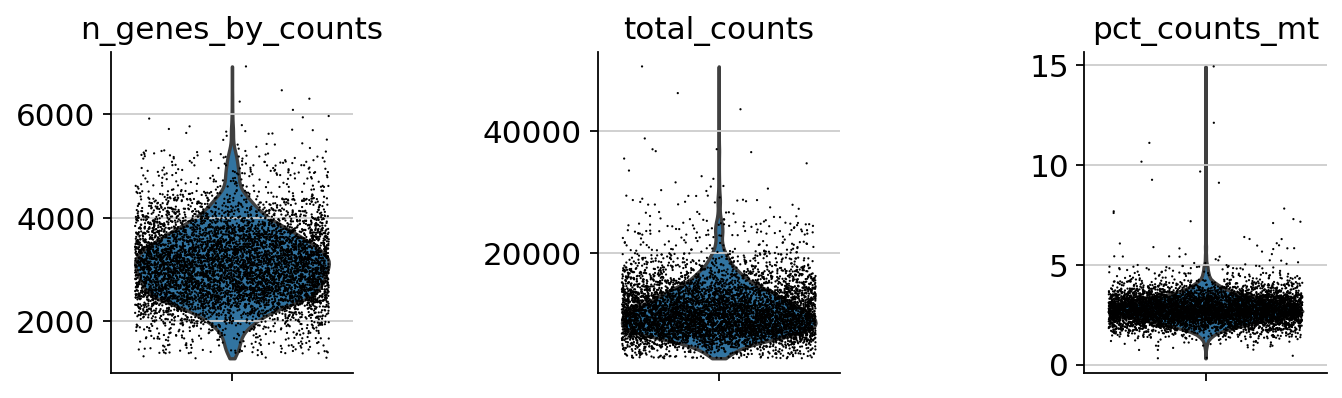

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

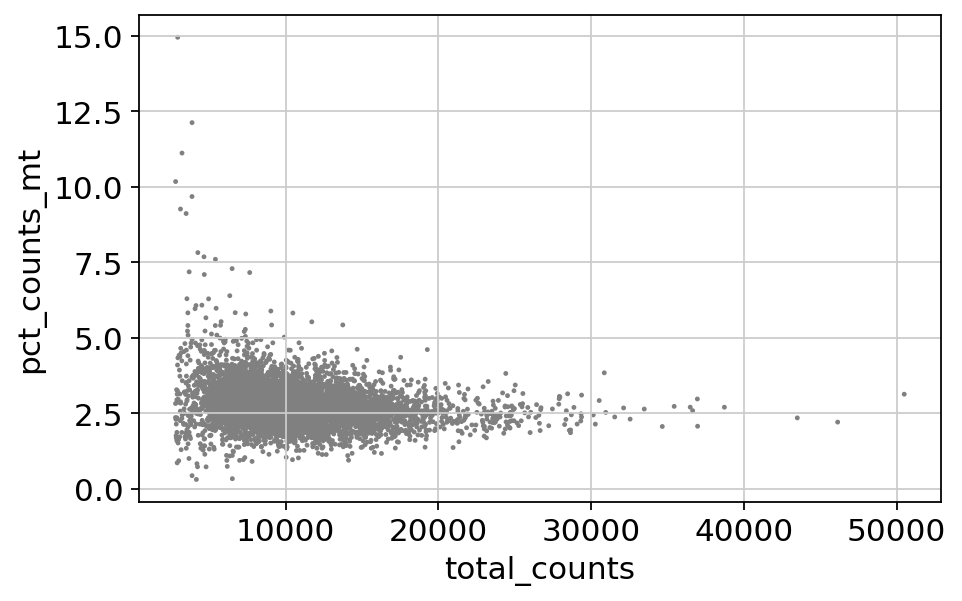

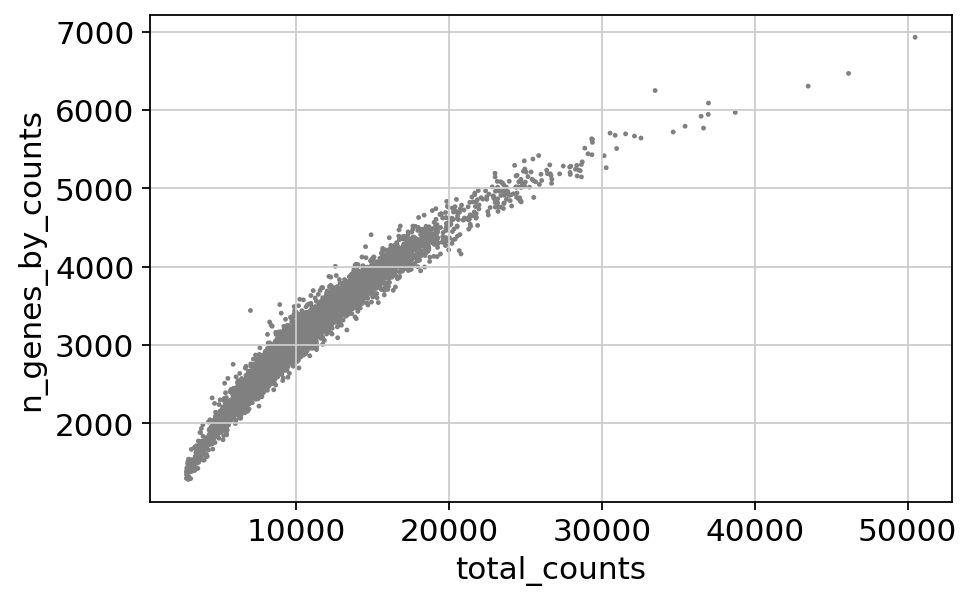

In [10]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Remove cells that have too many mitochondrial genes expressed or too many total counts.

In [11]:
adata = adata[adata.obs.total_counts < 40000, :]
adata = adata[adata.obs.n_genes_by_counts < (7500 if 'E14' in dataset else 6000), :]  # for E14: 7500, for E13: 6000
adata = adata[adata.obs.pct_counts_mt < (10 if 'E14' in dataset else 5), :]  # for E14: 10, for E13: 5
print(adata)

View of AnnData object with n_obs × n_vars = 6285 × 16237
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


In [12]:
adata.raw = adata.copy()

In [13]:
print(adata.X[100], min(adata.X[100]), max(adata.X[100]))
print(adata.raw.X[100], min(adata.raw.X[100]), max(adata.raw.X[100]))

[0. 2. 1. ... 0. 0. 0.] 0.0 101.0
[0. 2. 1. ... 0. 0. 0.] 0.0 101.0


In [ ]:
# adata.write('../ann_data/' + dataset + '_qc.h5ad')

In [ ]:
# Transpose and write to csv for cellassign

# df = pd.DataFrame(adata.X.transpose())
# df.index = adata.var_names
# df.columns = adata.obs_names
# df.to_csv('../ann_data/' + dataset + '_qc.csv')

In [ ]:
# adata = sc.read('../ann_data/E13_hom_qc.h5ad') # run this to start from here

## Normalization

Total-count normalize (library-size correct) the data matrix **X** to 40,000 genes per cell, so that counts become comparable among cells.

In [33]:
# sc.pp.normalize_total(adata, target_sum=1e4, key_added='size_factors')

normalizing counts per cell
    finished (0:00:00)


Logarithmize the data and identify highly-variable genes.

In [14]:
sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pl.highly_variable_genes(adata)

Filter using the highly variable genes.

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [15]:
# adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata)

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:03:09)


In [16]:
print(adata)

AnnData object with n_obs × n_vars = 6285 × 16237
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'log1p'


In [17]:
print(adata.raw.X[100], min(adata.raw.X[100]), max(adata.raw.X[100]))
print(adata.X[100], min(adata.X[100]), max(adata.X[100]))

[0. 2. 1. ... 0. 0. 0.] 0.0 101.0
[-0.04059487  0.8716643   1.1195458  ... -0.07004886 -0.06324553
 -1.0597578 ] -3.2320075 32.319603


In [18]:
# Write in h5ad file to use as an input to scDeepCluster
adata_norm_file = '../ann_data/' + dataset + '_norm.h5ad'
adata.write(adata_norm_file)

## Principal Component Analysis

In [18]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:07)


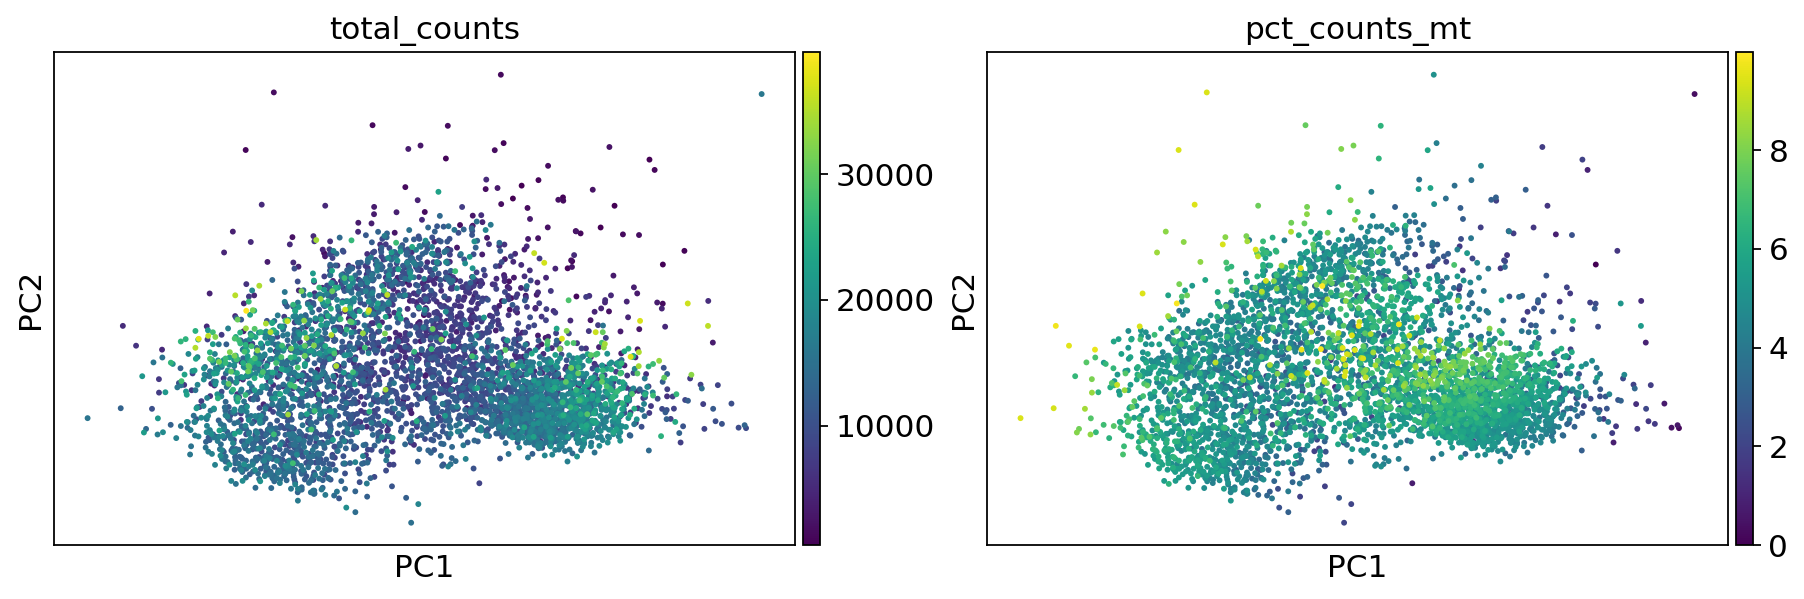

In [19]:
sc.pl.pca(adata, color=['total_counts', 'pct_counts_mt'])

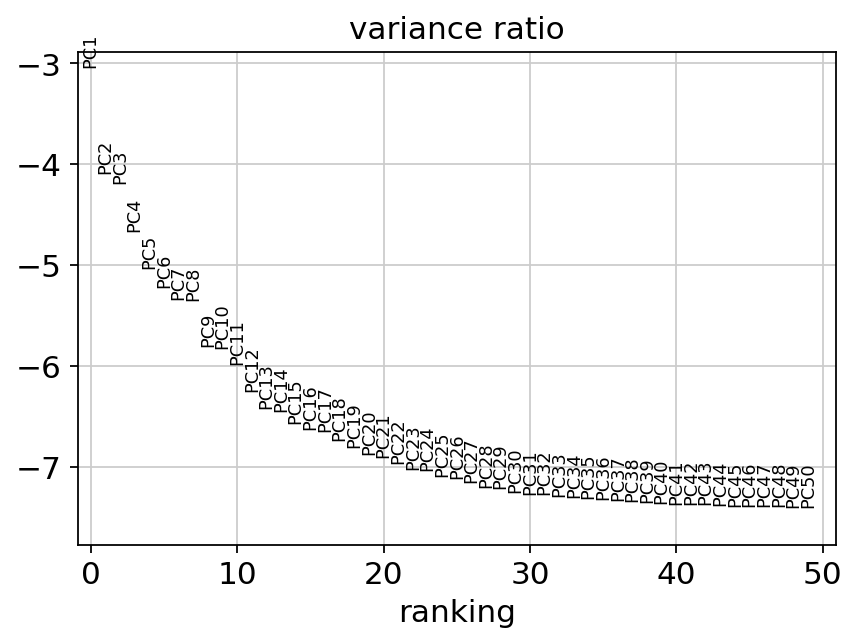

In [20]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

## Cell Cycle Scoring and Regression

### Check cell cycle effect on the dataset

1. PCA on 50 PCs
2. UMAP on 40 PCs (from the elbow plot above)
3. UMAP on the whole X

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    513 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    467 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
computing PCA
    with n_comps=50
    finished (0:00:00)


... storing 'phase' as categorical


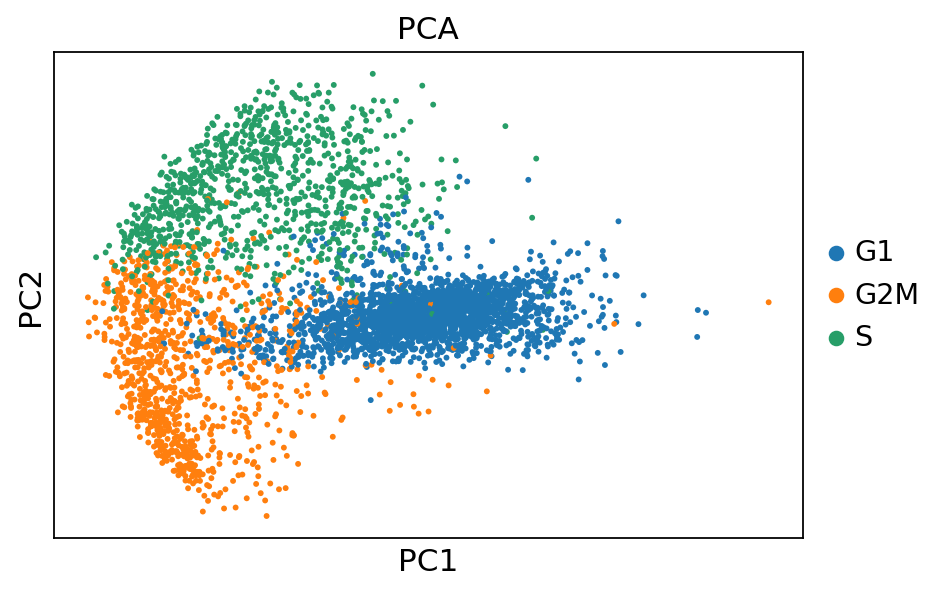

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


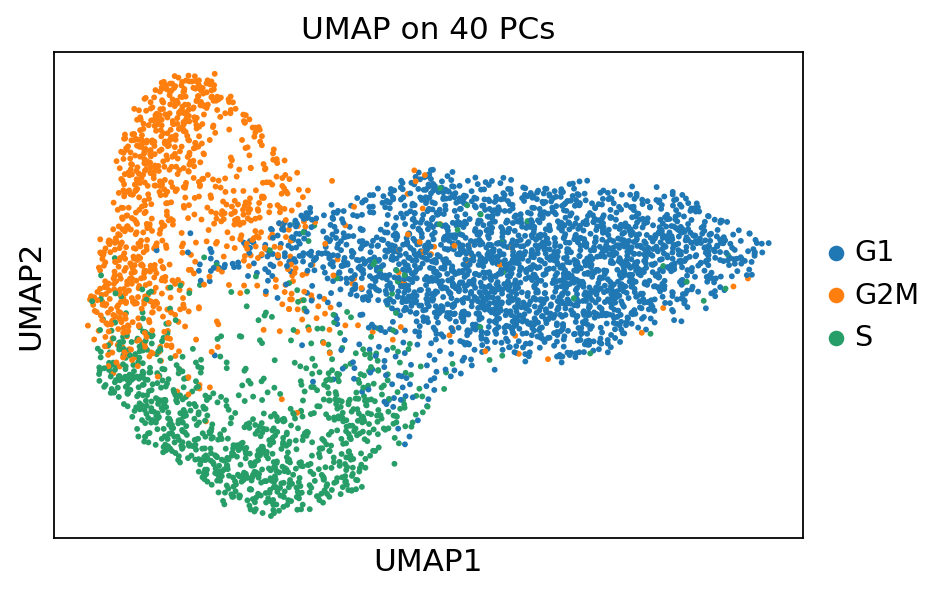

In [21]:
# Load cell cycle genes from file and split into S and G2M genes
cell_cycle_genes = [x.strip().lower().capitalize() for x in open('../preprocessing/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

# Perform cell cycle scoring
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
cc_phase = adata.obs.phase
adata_cc_genes = adata[:, cell_cycle_genes]  # Subset of the data using only the cell cycle phase genes

# PCA
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase', title='PCA')

# UMAP on 40 PCs
sc.pp.neighbors(adata_cc_genes, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_cc_genes)
sc.pl.umap(adata_cc_genes, color='phase', title='UMAP on 40 PCs')

### Regress out S score and G2M score

In [22]:
adata_no_cc = sc.pp.regress_out(adata, ['S_score', 'G2M_score'], copy=True)
sc.pp.scale(adata_no_cc, max_value=1)

regressing out ['S_score', 'G2M_score']


... storing 'phase' as categorical


    finished (0:01:00)


### Reproject dataset using the cell cycle genes to check that the cell cycle effect is now not present.

After regressing out the cell cycle
computing PCA
    with n_comps=50
    finished (0:00:00)


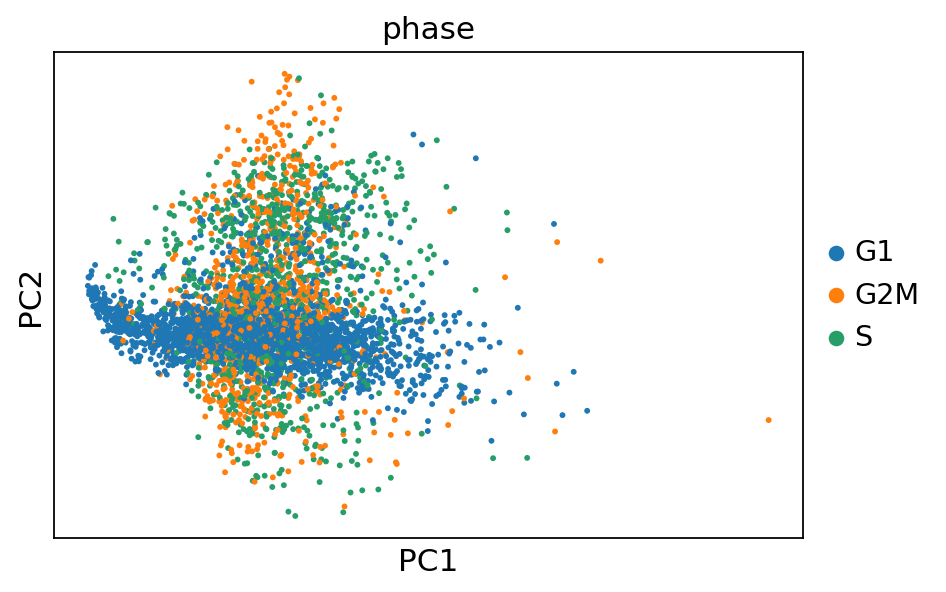

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


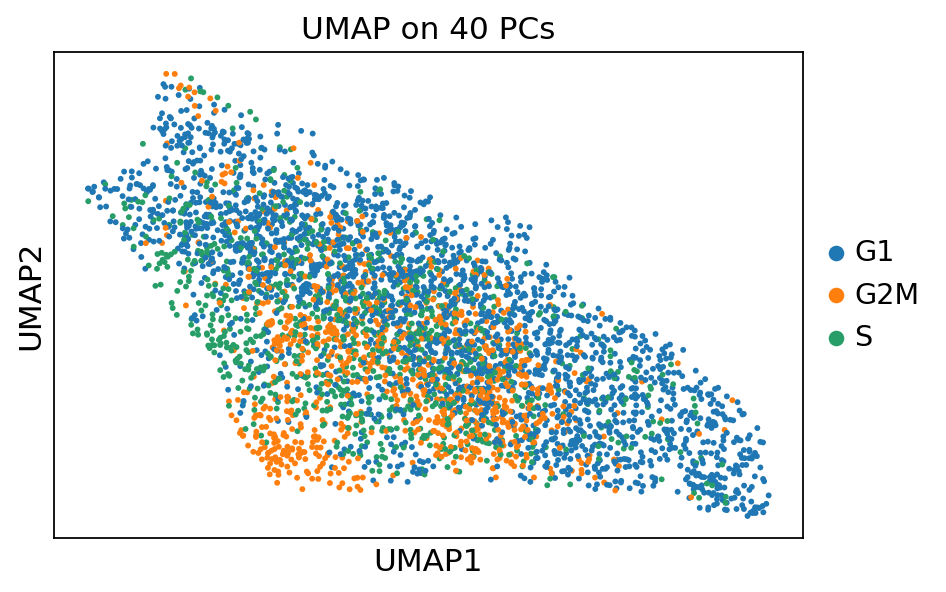

In [23]:
adata_cc_genes_regressed = adata_no_cc[:, cell_cycle_genes]
print('After regressing out the cell cycle')

# PCA
sc.tl.pca(adata_cc_genes_regressed)
sc.pl.pca_scatter(adata_cc_genes_regressed, color='phase')

# UMAP on 40 PCs
sc.pp.neighbors(adata_cc_genes_regressed, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_cc_genes_regressed)
sc.pl.umap(adata_cc_genes_regressed, color='phase', title='UMAP on 40 PCs')

## Clustering the neighborhood graph using the Leiden graph-clustering method

In [24]:
sc.pp.neighbors(adata_no_cc, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata_no_cc)
sc.tl.umap(adata_no_cc)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


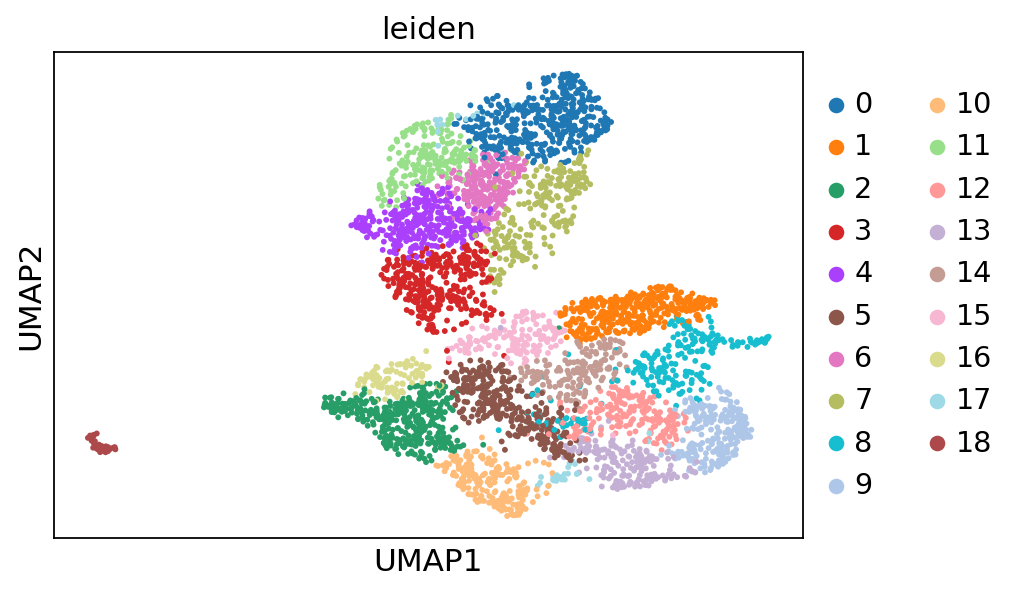

In [25]:
sc.pl.umap(adata_no_cc, color=['leiden'])

In [26]:
# Remove Cajal Retzius cells
if dataset in ['E14_hom', 'E14_het']:
#     cajal_retzius_cells = '17'
    cajal_retzius_cells = '18'
elif dataset == 'E13_hom':
    cajal_retzius_cells = '11'
elif dataset == 'E13_het':
    cajal_retzius_cells = '11'
    
adata_no_cc_update = adata_no_cc[~adata_no_cc.obs['leiden'].isin([cajal_retzius_cells]),:]

In [ ]:
adata_no_cc_update = adata_no_cc.copy()

### Cell types

1. Neural progenitors: Pax6, Vim, Sox2
2. Intermediate progenitors: Eomes, Btg2,
3. Post-mitotic neurons: Tbr1, Sox5

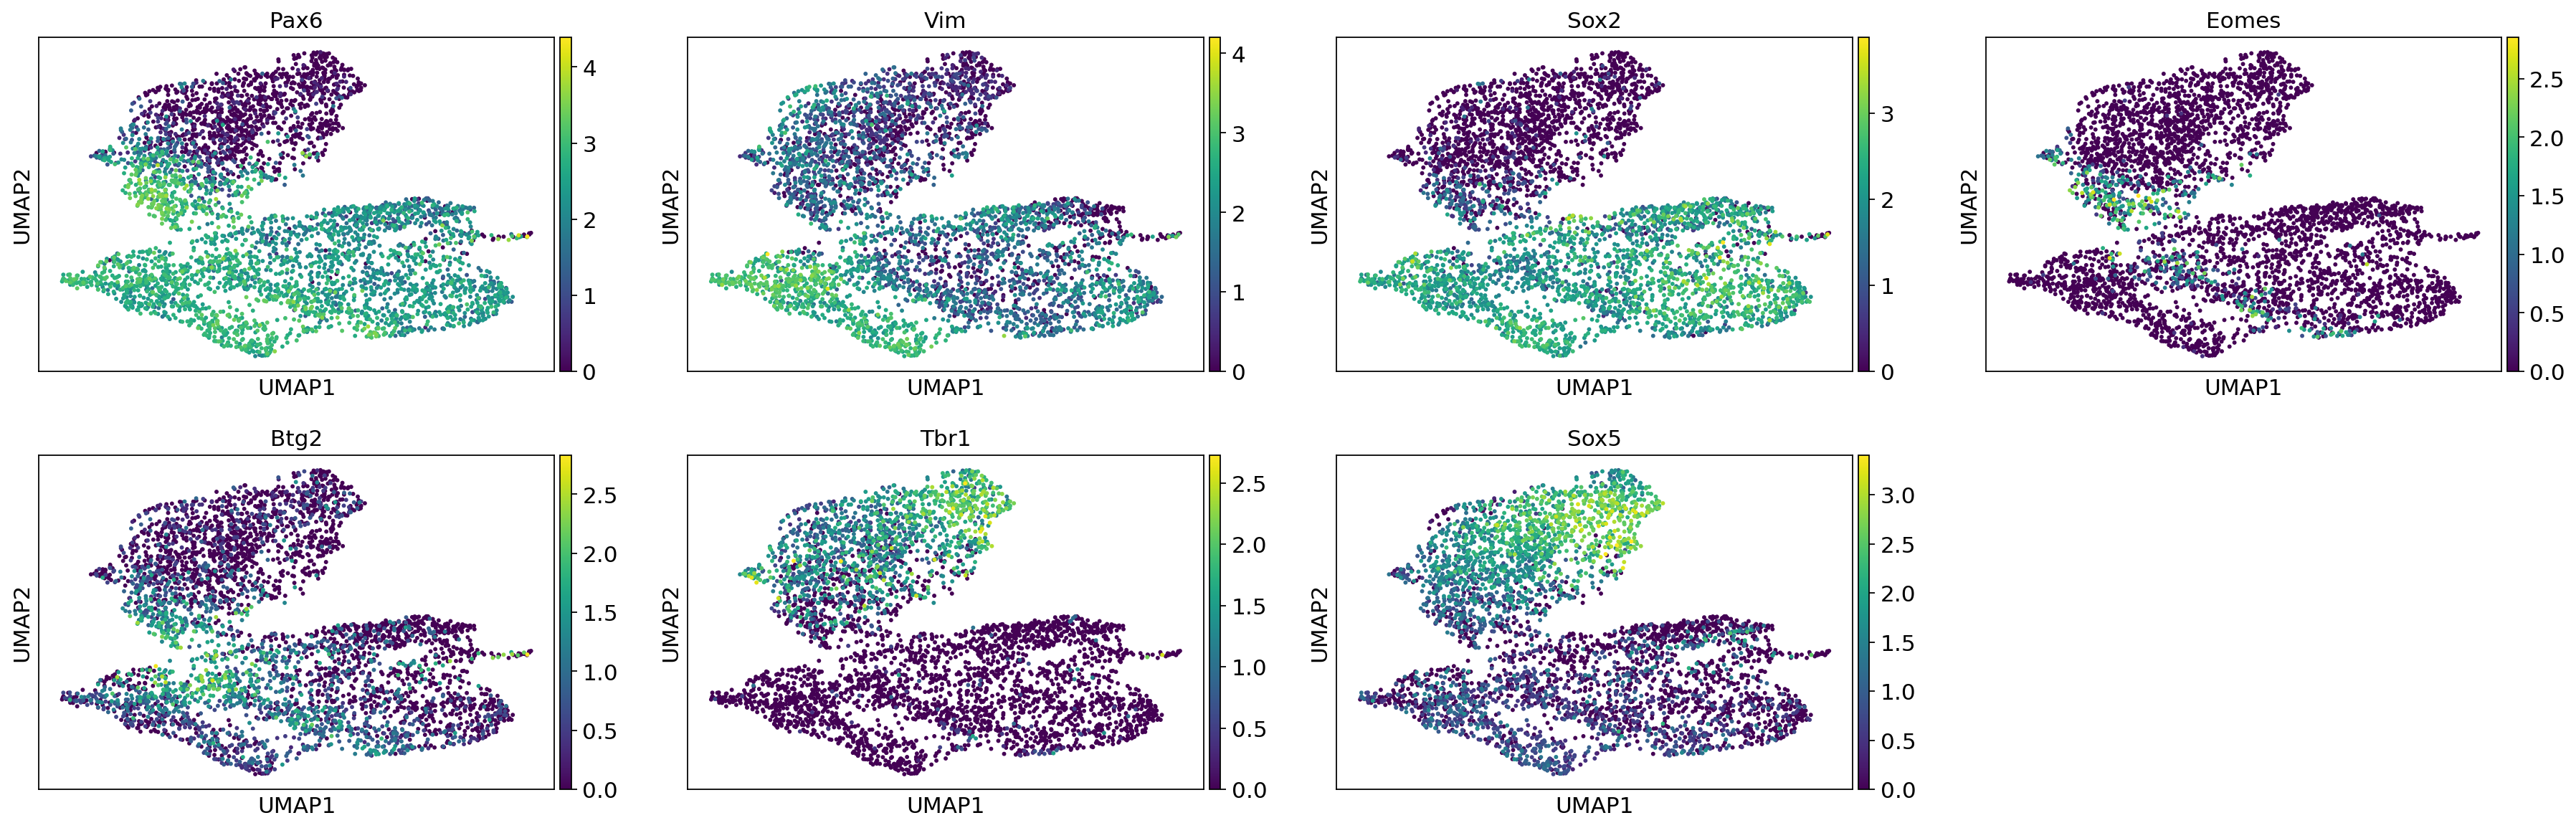

In [27]:
neural_progen = ['Pax6', 'Vim', 'Sox2']
intermediate_progen = ['Eomes', 'Btg2']
post_mitotic = ['Tbr1', 'Sox5']
sc.pl.umap(adata_no_cc_update, color=neural_progen+intermediate_progen+post_mitotic)

Ectopic marker genes: 'Gsx2', 'Prdm13', 'Dlx1', 'Dlx2', 'Dlx5', 'Gad1', 'Gad2', 'Ptf1a', 'Msx3', 'Helt', 'Olig3'

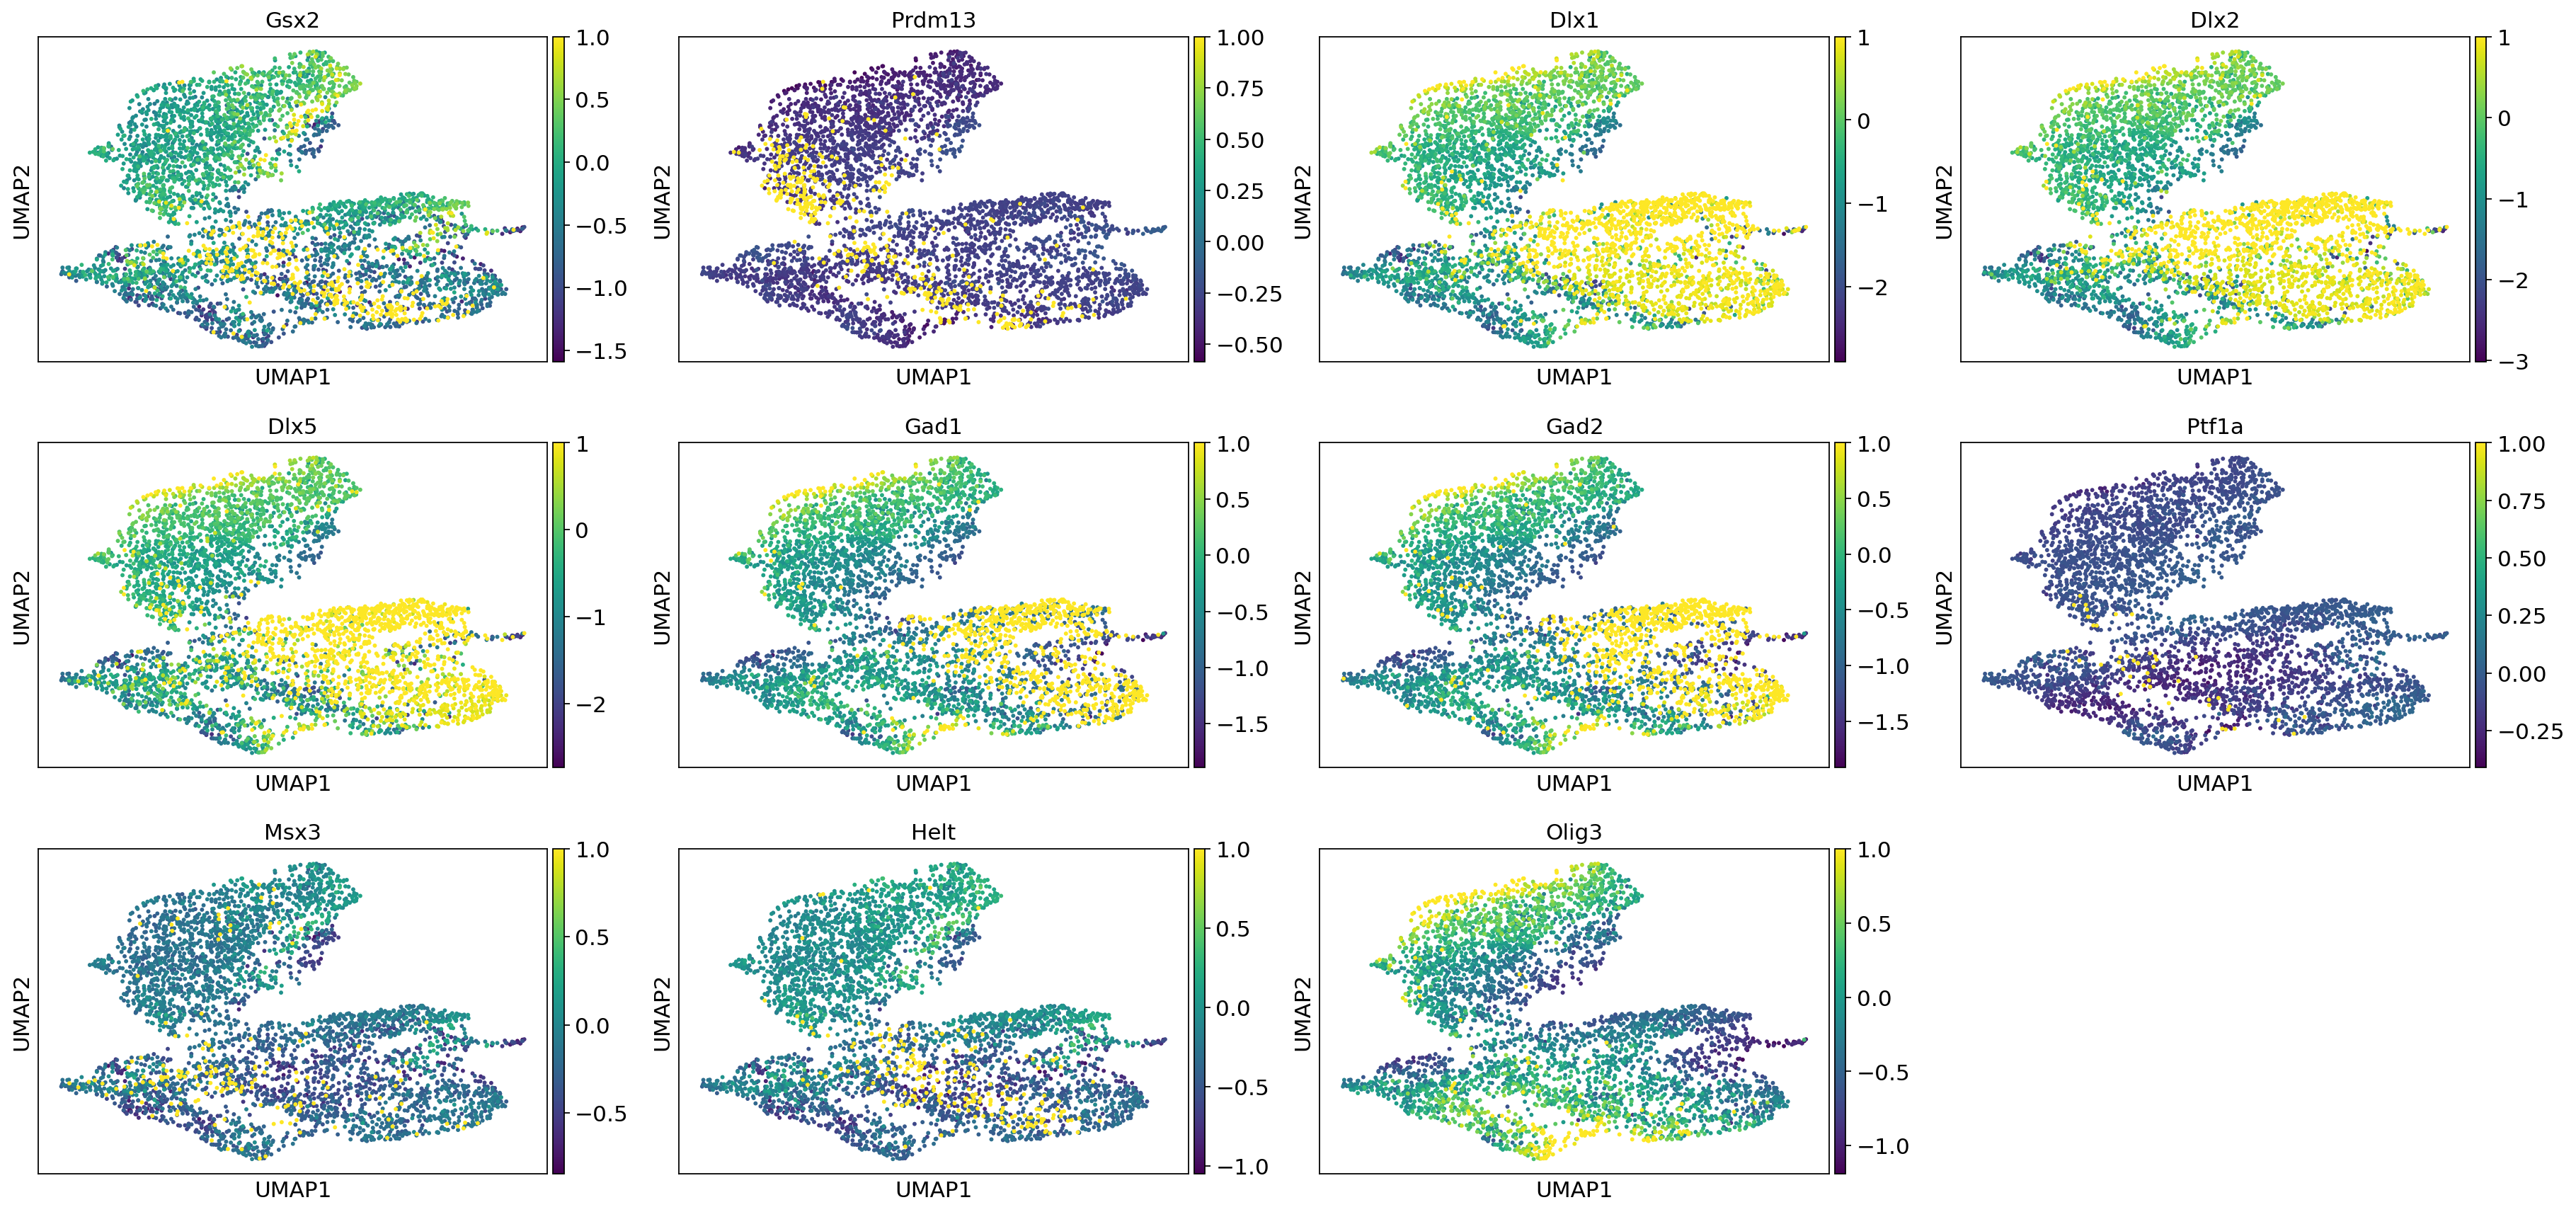

In [28]:
ectopic_marker_genes = ['Gsx2', 'Prdm13', 'Dlx1', 'Dlx2', 'Dlx5', 'Gad1', 'Gad2', 'Ptf1a', 'Msx3', 'Helt', 'Olig3']

if dataset == 'E14_hom':
#     ectopic_marker_genes.remove('Olig3')
    pass
elif dataset == 'E13_hom':
    for gene in ['Olig3']:
#     for gene in ['Gad1', 'Gad2', 'Helt', 'Olig3']:
        ectopic_marker_genes.remove(gene)
elif dataset == 'E14_het':
    for gene in ['Gsx2', 'Prdm13', 'Gad1', 'Ptf1a', 'Msx3', 'Helt', 'Olig3']:
        ectopic_marker_genes.remove(gene)
elif dataset == 'E13_het':
    for gene in ['Gsx2', 'Prdm13', 'Dlx1', 'Dlx5', 'Gad1', 'Gad2', 'Ptf1a', 'Helt', 'Olig3']:
        ectopic_marker_genes.remove(gene)
    
sc.pl.umap(adata_no_cc_update, color=ectopic_marker_genes, use_raw=False)

## Write data to csv

In [29]:
print(adata_no_cc_update)
df = pd.DataFrame(adata_no_cc_update.X)
df.index = adata_no_cc_update.obs_names
df.columns = adata_no_cc_update.var_names
file = '../ann_data/' + dataset + '_no_cc.csv'

df.to_csv(file)
print('File {} created'.format(file))

View of AnnData object with n_obs × n_vars = 4263 × 16899
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'size_factors', 'S_score', 'G2M_score', 'phase', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
File ../ann_data/E14_hom_no_cc.csv created


In [30]:
h5ad_file = '../ann_data/' + dataset + '_no_cc.h5ad'
adata_no_cc_update.write(h5ad_file)